In [1]:
# 把scLLM的位置添加进system path保证可以import scLLM
import sys
root = "/home/shi/WorkSpace/projects/scMultiNet_Data/"
code_loc = "/home/shi/WorkSpace/projects/scMultiNet_workspace/"
sys.path.append(code_loc)
# 数据集读取
import dill
raw_data_loc = root + "/Step_1_data/Dataset_cook/TrVal_dataset_PC_TGFb_GTlabel5.pkl"
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [trainset,valset,_,label_dict] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(trainset))
print("valset size: ",len(valset)) if valset is not None else print("no valset")
print(label_dict)

# vocab 读取 
vocab_loc = code_loc + "/Experiment/support_data/vocab_16k.json"
import json
with open(vocab_loc,"r") as f:
    vocab = json.load(f)


# 根据字典的值进行排序，并获取排序后的键
sorted_genes = sorted(vocab, key=vocab.get)

# 现在 sorted_genes 是一个按值排序的基因名称列表
sorted_genes.append("CLS")
print(sorted_genes[:20])
print(len(sorted_genes))

trainset size:  5881
valset size:  1471
{'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}
['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AANAT', 'AAR2', 'AARS2', 'AARSD1', 'AASDH']
16907


In [2]:
import numpy as np

# 步骤 0: 数据位置
data_locs = [
    root+"/Step_6_data/data/multi_cls0.pkl",
    root+"/Step_6_data/data/multi_cls1.pkl",
    root+"/Step_6_data/data/multi_cls2.pkl",
    root+"/Step_6_data/data/multi_cls3.pkl",
    root+"/Step_6_data/data/multi_cls4.pkl",
]
# 步骤 1: 加载数据
# 文件保存在pkl
import pickle
def load_data(file_path):
    with open(file_path, 'rb') as f:
        [pred_list,label_list,weights_list,weighted_feature_list] = pickle.load(f)
    print(pred_list.shape)
    print(label_list.shape)
    print(weights_list.shape)
    print(weighted_feature_list.shape)
    return pred_list,label_list,weights_list,weighted_feature_list

pred_lists = []
weights_lists = []
weighted_feature_lists = []
for l in data_locs:
    pred_list,label_list,weights_list,weighted_feature_list = load_data(l)
    pred_lists.append(pred_list)
    weights_lists.append(weights_list)
    weighted_feature_lists.append(weighted_feature_list)

(1471, 2)
(1471, 1)
(1471, 16907)
(1471, 16907)
(1471, 2)
(1471, 1)
(1471, 16907)
(1471, 16907)
(1471, 2)
(1471, 1)
(1471, 16907)
(1471, 16907)
(1471, 2)
(1471, 1)
(1471, 16907)
(1471, 16907)
(1471, 2)
(1471, 1)
(1471, 16907)
(1471, 16907)


In [3]:
# weighted_feature_lists == attention x gene expression


# 初始化 model_weights
model_weight_features = np.zeros([weighted_feature_lists[0].shape[0] , weighted_feature_lists[0].shape[1]])
# 初始化 avg_weights
avg_0 = [np.zeros([weighted_feature_lists[0].shape[1],1]),0]
avg_1 = [np.zeros([weighted_feature_lists[0].shape[1],1]),0]
avg_2 = [np.zeros([weighted_feature_lists[0].shape[1],1]),0]
avg_3 = [np.zeros([weighted_feature_lists[0].shape[1],1]),0]
avg_4 = [np.zeros([weighted_feature_lists[0].shape[1],1]),0]
# 遍历每个样本
for i in range(weighted_feature_lists[0].shape[0]):
    # 获取当前样本的真实类别
    label = int(label_list[i])

    # 选择并复制对应类别的 weights_list
    model_weight_features[i, :] = weighted_feature_lists[label][i, :]
    # 更新 avg_weights
    if label == 0:
        avg_0[0] += weighted_feature_lists[label][i, :].reshape(-1,1)
        avg_0[1] += 1
    elif label == 1:
        avg_1[0] += weighted_feature_lists[label][i, :].reshape(-1,1)
        avg_1[1] += 1
    elif label == 2:
        avg_2[0] += weighted_feature_lists[label][i, :].reshape(-1,1)
        avg_2[1] += 1
    elif label == 3:
        avg_3[0] += weighted_feature_lists[label][i, :].reshape(-1,1)
        avg_3[1] += 1
    elif label == 4:
        avg_4[0] += weighted_feature_lists[label][i, :].reshape(-1,1)
        avg_4[1] += 1

# 计算平均权重
avg_0 = avg_0[0] / avg_0[1]
avg_1 = avg_1[0] / avg_1[1]
avg_2 = avg_2[0] / avg_2[1]
avg_3 = avg_3[0] / avg_3[1]
avg_4 = avg_4[0] / avg_4[1]

rev_label_dict = {v:k for k,v in label_dict.items()}
dict_score = {
    rev_label_dict[0]:avg_0.flatten(),
    rev_label_dict[1]:avg_1.flatten(),
    rev_label_dict[2]:avg_2.flatten(),
    rev_label_dict[3]:avg_3.flatten(),
    rev_label_dict[4]:avg_4.flatten(),
}

In [4]:

# 根据字典的值进行排序，并获取排序后的键
sorted_genes = sorted(vocab, key=vocab.get)

# 获取每个类别的前30个基因
top_genes_per_class = {}
top_n = 10 # 取前30个基因

for class_name, scores in dict_score.items():
    # 将分数和基因名配对并按分数降序排序
    gene_scores = sorted(zip(sorted_genes, scores), reverse=True)
    # 按分数降序排序
    sorted_gene_score_pairs = sorted(gene_scores, key=lambda x: x[1], reverse=True)

    ## 取前30个基因（或者所有基因如果不足30个）
    top_genes_per_class[class_name] = sorted_gene_score_pairs[:top_n]

# 仅显示基因名，不显示分数
top_genes_names_sorted = {class_name: [gene for gene, score in pairs] for class_name, pairs in top_genes_per_class.items()}
top_genes_names_sorted

{'3d': ['RPL35A',
  'RPL23A',
  'EEF1B2',
  'PTMA',
  'RPS5',
  'FTH1',
  'TMSB10',
  'RPS27',
  'RPS7',
  'RPS2'],
 '7d': ['ANAPC11',
  'COX8A',
  'SNF8',
  'EEF2',
  'NDUFB10',
  'ENY2',
  'SEC61B',
  'MRPL51',
  'DBI',
  'COX6B1'],
 '1d': ['RPS26',
  'RPL35A',
  'RPL23',
  'PRDX1',
  'EIF3K',
  'RPL27',
  'OST4',
  'ANAPC11',
  'PRELID1',
  'RPL15'],
 '8h': ['PTMA',
  'RPL37',
  'UQCRH',
  'RPS17',
  'PPIA',
  'RAN',
  'HINT1',
  'RPL12',
  'TMSB10',
  'RPL38'],
 '0d': ['POP7',
  'PPM1G',
  'HMGN3',
  'TIMM10',
  'ERP29',
  'ZNHIT1',
  'MRPL43',
  'TXNL4A',
  'ATP6V0B',
  'SF3B5']}

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# important_genes_with_labels 字典和 vocab 字典
important_genes_with_labels = top_genes_names_sorted

# 逆转vocab字典以便通过基因名获取索引
gene_to_index = {gene: index for gene, index in vocab.items()}

# 对每个类别进行处理
concatenated_matrix = {}
all_genes = []
for label in  ["0d","8h","1d","3d","7d",]:
    all_genes += important_genes_with_labels[label]
for label in important_genes_with_labels.keys():
    print(label)
    print(label_dict[label])
    # 获取当前类别的样本索引
    indices = np.where(label_list == label_dict[label])[0]

    # 提取对应类别的样本
    class_features = weighted_feature_lists[label_dict[label]][indices, :]
    print(class_features.shape)
    # 提取重要的基因
    important_indices = [gene_to_index[gene] for gene in all_genes]
    important_features = class_features[:, important_indices]
    print(important_features.shape)
    # normalise (value - mid)/mean
    #important_features = (important_features - np.mean(important_features, axis=0)) / np.std(important_features, axis=0)
    # normalise (value - min)/(max-min)
    #important_features = (important_features - np.median(important_features, axis=0)) / (np.max(important_features, axis=0) - np.min(important_features, axis=0))

    # 拼接到总矩阵
    concatenated_matrix.update({label:important_features.T})

matrix_list = []
for label in ["0d","8h","1d","3d","7d",]:
    matrix_list.append(concatenated_matrix[label])
# 合并所有类别的矩阵
final_matrix = np.concatenate(matrix_list, axis=1)

# normalise (value - mid)/mean
final_matrix = (final_matrix - np.median(final_matrix, axis=0)) / np.std(final_matrix, axis=0)#(np.max(final_matrix, axis=0) - np.min(final_matrix, axis=0))

3d
0
(341, 16907)
(341, 50)
7d
1
(101, 16907)
(101, 50)
1d
2
(350, 16907)
(350, 50)
8h
3
(396, 16907)
(396, 50)
0d
4
(283, 16907)
(283, 50)


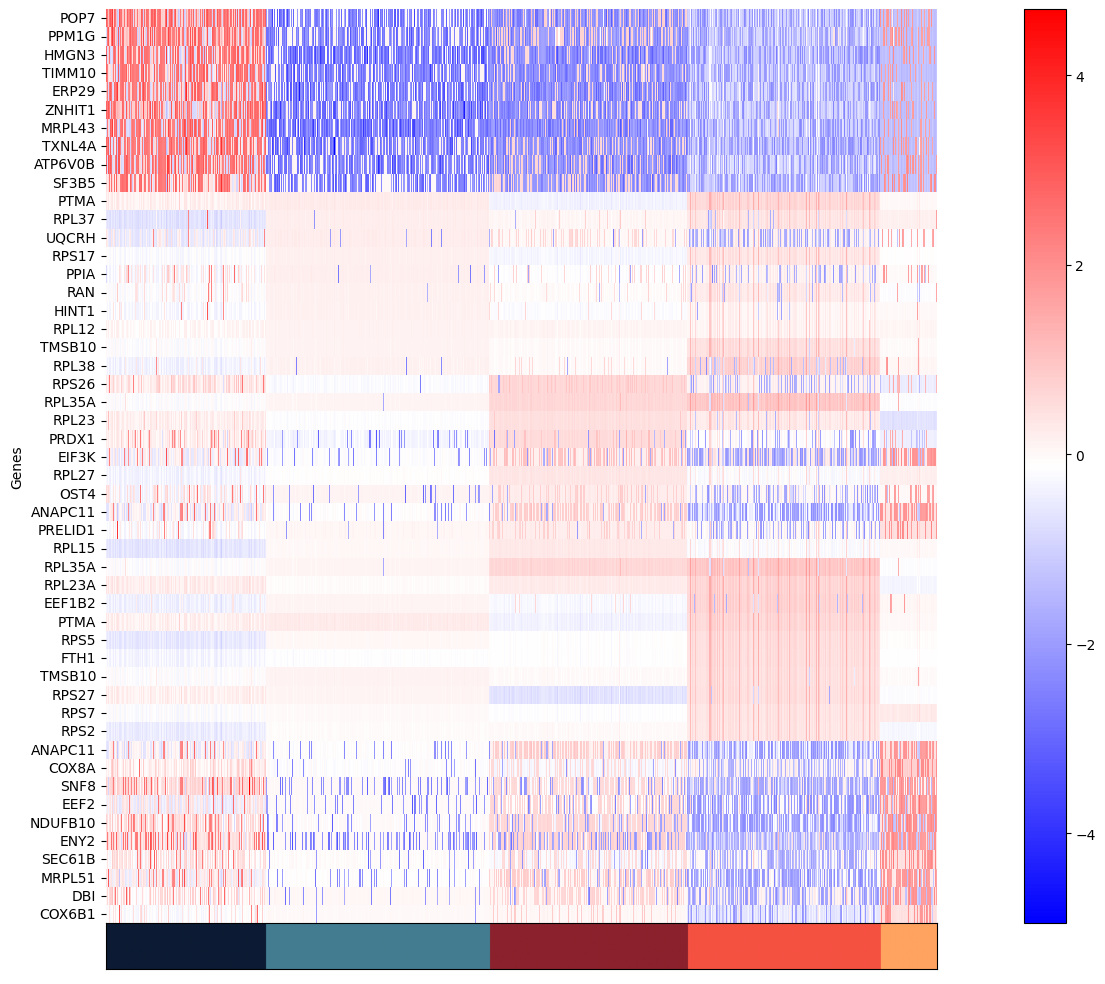

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# ... 你之前的代码，用于准备 final_matrix 和 all_genes ...
labels_order = ["0d", "8h", "1d", "3d", "7d"]

# 初始化 sample_labels 数组
sample_labels = []

# 遍历每个类别，添加对应数量的标签
for label in labels_order:
    # 获取当前类别的样本数
    num_samples = concatenated_matrix[label].shape[1]  # 第二维度是样本数
    # 将类别标签添加到 sample_labels 数组中
    sample_labels.extend([label] * num_samples)

# 将 sample_labels 转换为 numpy 数组
sample_labels = np.array(sample_labels)
# 假设 sample_labels 是一个与样本相对应的类别数组
label_order = ["0d", "8h", "1d", "3d", "7d"]
colors = ['#0c1b33', '#437c90', '#8b212c', '#f55141', '#ffa360']
import matplotlib.colors as mcolors
colors_rgba = [mcolors.to_rgba(c) for c in colors]
label_colors = {l:c for l, c in zip(label_order, colors_rgba)}
colors = [label_colors[label] for label in sample_labels]
# 注意: 你需要根据实际情况生成这个数组，以匹配你的样本

# 创建包含两个子图的图形：一个用于热图，另一个用于显示类别

# 创建 figure 和 GridSpec
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.05],width_ratios=[1,0.05], hspace=0.0)

# 第一个子图：热图
ax0 = plt.subplot(gs[0])
heatmap = sns.heatmap(final_matrix, cmap='bwr', yticklabels=all_genes, xticklabels=False, ax=ax0,cbar=False)
plt.ylabel('Genes')

# 添加颜色条
axc = plt.subplot(gs[1])
cbar = plt.colorbar(heatmap.collections[0], cax=axc, orientation='vertical')
cbar.ax.xaxis.set_ticks_position('top')

# 第二个子图：类别颜色条
ax1 = plt.subplot(gs[2])

# 显示颜色条
ax1.imshow([colors], aspect='auto')


ax1.set_yticks([])
ax1.set_xticks([])

# 调整子图的边距，确保对齐
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# 保存和显示图形
plt.savefig(root+"/Step_6_data/heatmap.pdf")
plt.show()